# Make Catalog (Run 13229)

Let's make a catalog out of the results of the full run `u/jesteves/2023.06.12/test_b`

In [1]:
! eups list -s lsst_distrib

   gdf42428520+f51fc98903 	current w_2023_23 setup


In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import lsst.daf.butler as daf_butler
import lsst.afw.math as afw_math
from matplotlib import pyplot as plt
from astropy.stats import sigma_clip
from scipy.stats import skew
from matplotlib.patches import Rectangle

import lsst.afw.display as afwDisplay
from astropy.visualization import imshow_norm, MinMaxInterval,AsinhStretch,LinearStretch,SqrtStretch,ContrastBiasStretch,ZScaleInterval,AsymmetricPercentileInterval,ManualInterval

# from myutils import *

In [3]:
import seaborn as sns
sns.set_context('talk')

# Run 12 Jun

In [4]:
from lsst.daf.butler import Butler
repo = '/sdf/group/rubin/repo/main/butler.yaml'
collections = 'u/jesteves/2023.06.12/test_b'
butler = Butler(repo,collections=collections)
registry = butler.registry

In [5]:
### check repo
for dtype in registry.queryDatasetTypes():
    try:
        datasetRefs = list(registry.queryDatasets(datasetType=dtype,collections=collections))
        if len(datasetRefs)>1:
            print(len(datasetRefs), dtype)
    except:
        i=1

6188213 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
378 DatasetType('defects', {instrument, detector}, Defects, isCalibration=True)
378 DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
378 DatasetType('flat', {band, instrument, detector, physical_filter}, ExposureF, isCalibration=True)
378 DatasetType('dark', {instrument, detector}, ExposureF, isCalibration=True)
2 DatasetType('packages', {}, Packages)
26568 DatasetType('postISRCCD', {band, instrument, detector, physical_filter, exposure}, Exposure)
26568 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
2 DatasetType('isr_config', {}, Config)
378 DatasetType('linearizer', {instrument, detector}, Linearizer, isCalibration=True)
26568 DatasetType('isr_log', {band, instrument, detector, physical_filter, exposure}, ButlerLogRecords)
2 DatasetType('gridFit_config', {}, Config)
2 DatasetType('spotSrc_schema', {}, SourceCatalog

In [6]:
collections

'u/jesteves/2023.06.12/test_b'

In [7]:
kwargs={
"datasetType": "gridSpotSrc",
"collections": collections,
"where":
"""
instrument='LSSTCam' and
exposure.science_program in ( '13229' )
"""
}

_datasetRefs = list(registry.queryDatasets(**kwargs))
print( f"You have {len(_datasetRefs)} in this repository with the condition supplied {kwargs}")

You have 6497 in this repository with the condition supplied {'datasetType': 'gridSpotSrc', 'collections': 'u/jesteves/2023.06.12/test_b', 'where': "\ninstrument='LSSTCam' and\nexposure.science_program in ( '13229' )\n"}


In [8]:
nall = len(_datasetRefs)
nimages_per_det = np.round(nall/189,2)
print(f'There is in average {nimages_per_det} images per detector')

There is in average 34.38 images per detector


### Selecting only images with grid

For a given raft all detectors had imaged read-out. However, only two have a grid on them. Selecting by the number of sources gives us the images with the spot grid.

In [9]:
nsrcs = []
datasetRefs = []
nSrcs = []
print('Number of sources inside grid spot catalog')
print('A common half grid should have at least 1000 spots')
print('Starting Loading the Catalogs') 
for i,dR in enumerate(_datasetRefs):
    cat = butler.get('gridSpotSrc',dR.dataId).asAstropy()
    print('Reading %i/%i - size: %i'%(i,nall,len(cat)))
    nSrcs.append(len(cat))    

Number of sources inside grid spot catalog
A common half grid should have at least 1000 spots
Starting Loading the Catalogs
Reading 0/6497 - size: 1023
Reading 1/6497 - size: 229
Reading 2/6497 - size: 259
Reading 3/6497 - size: 227
Reading 4/6497 - size: 240
Reading 5/6497 - size: 244
Reading 6/6497 - size: 235
Reading 7/6497 - size: 235
Reading 8/6497 - size: 238
Reading 9/6497 - size: 1058
Reading 10/6497 - size: 244
Reading 11/6497 - size: 255
Reading 12/6497 - size: 224
Reading 13/6497 - size: 265
Reading 14/6497 - size: 248
Reading 15/6497 - size: 237
Reading 16/6497 - size: 243
Reading 17/6497 - size: 238
Reading 18/6497 - size: 254
Reading 19/6497 - size: 269
Reading 20/6497 - size: 246
Reading 21/6497 - size: 253
Reading 22/6497 - size: 236
Reading 23/6497 - size: 240
Reading 24/6497 - size: 256
Reading 25/6497 - size: 235
Reading 26/6497 - size: 221
Reading 27/6497 - size: 228
Reading 28/6497 - size: 255
Reading 29/6497 - size: 28
Reading 30/6497 - size: 1099
Reading 31/6497 

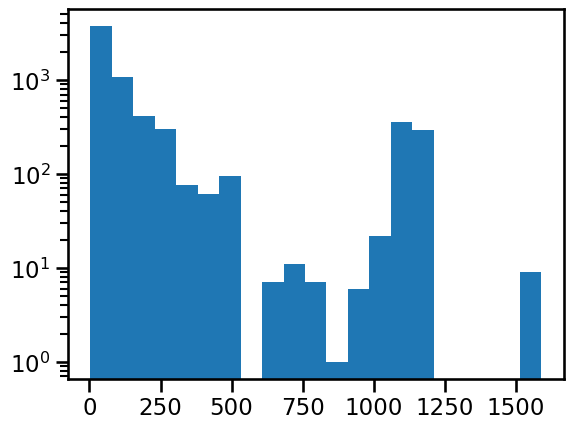

In [89]:
_ = plt.hist(nSrcs,bins=21)
plt.yscale('log')

In [11]:
# select only the half-grid images
sel = np.where(np.array(nSrcs)>700)[0]
datasetRefs = [_datasetRefs[i] for i in sel]
print(f'You have {sel.size} spot catalogs with half-grid')

You have 701 spot catalogs with half-grid


## Grid Pairs

In [12]:
from collections import Counter
def find_pairs(a):
    pairExpId = [item for item, count in Counter(a).items() if count > 1]
    pairs = [np.where(a==expid)[0] for expid in pairExpId]
    return pairs

def get_pairs(a):
    pairs = find_pairs(a)
    # join repeated ids in the same id
    pairID = np.full(sel.size,-1,dtype=np.int64)
    for i in range(len(pairs)):
        for ix in pairs[i]:
            pairID[ix] = i
    return pairID

In [75]:
from astropy.table import Table

info = dict.fromkeys(['objID','pairID','expID','detector','ccd_type'])
info['objID'] = np.arange(sel.size,dtype=np.int16)
info['detector'] = np.array([datasetRefs[i].dataId['detector'] for i in range(sel.size)])
info['expID'] = np.array([datasetRefs[i].dataId['exposure'] for i in range(sel.size)],dtype=np.int64)
info['ccd_type'] = np.array([butler.get('raw.metadata',datasetRefs[i].dataId).toDict()['CCD_MANU'] for i in range(sel.size)])
info['pairID'] = get_pairs(info['expID'])
# info['pairID'] = find_pairs(info['expID'])
info = Table(info)

In [76]:
grid_cols = ['GRID_X0', 'GRID_X0ERR', 'GRID_Y0', 'GRID_Y0ERR', 'GRID_THETA', 'GRID_THETAERR']

def get_grid_fit(dR):
    md = butler.get('gridSpotSrc',dR.dataId).getMetadata().toDict()
    return {col:md[col] for col in grid_cols}

def get_grid_results(expids):
    out = Table(names=grid_cols)
    for exp in expids:
        vals = get_grid_fit(exp)
        out.add_row(vals)
    out['objID'] = np.arange(len(expids),dtype=np.int16)
    return out

griD = get_grid_results(datasetRefs)

In [77]:
from astropy.table import join

data = join(info,griD,keys='objID')
data

objID,pairID,expID,detector,ccd_type,GRID_X0,GRID_X0ERR,GRID_Y0,GRID_Y0ERR,GRID_THETA,GRID_THETAERR
int16,int64,int64,int64,str3,float64,float64,float64,float64,float64,float64
0,0,3021122200113,0,ITL,2099.02849864496,0.0177006235979026,4132.20409800422,0.0199621638940154,0.0926404839494927,1.37990109862719e-05
1,1,3021122200122,0,ITL,4205.42718355139,0.0247019701495282,2033.78926527628,0.0234907790392758,0.0926780103674824,2.55579718851088e-05
2,2,3021122200114,1,ITL,2080.78445629545,0.0894321473712502,4134.72618196555,0.0892679751217166,0.0922229761865131,7.72490807245766e-05
3,1,3021122200122,1,ITL,-16.1194264638175,0.0164846616317853,2030.48400249957,0.0143100640308392,0.092469852222462,1.35409803737328e-05
4,3,3021122200123,1,ITL,4185.63406163561,0.0211289573357938,2036.21328012476,0.0189587584427154,0.0923444881211001,2.05265087815274e-05
5,4,3021122200115,2,ITL,2061.79092170139,0.015002293341214,4144.86454567514,0.0151757650161693,0.0918840244502103,1.26976192642381e-05
6,3,3021122200123,2,ITL,-36.2099904451554,0.0166478510736018,2041.15859822851,0.0143738384270093,0.0920329264377883,1.36810555699638e-05
7,5,3021122200124,2,ITL,4166.29666010372,0.0210739374888225,2045.77775181059,0.0192738915616518,0.0918500639453451,2.09759231343132e-05
8,0,3021122200113,3,ITL,2101.77734569986,0.0168534159848475,-94.2454125727003,0.0191536167923238,0.0936072176970267,1.80285714292841e-05


In [78]:
from sklearn.cluster import KMeans
# Create a KMeans instance with 5 clusters
kmeans = KMeans(n_clusters=5)

# Fit the data to the K-means model
pos = np.c_[data['GRID_X0'],data['GRID_Y0']]
kmeans.fit(pos)

# Get the cluster labels for each data point
labels = kmeans.labels_

data['group'] = labels
data['orientation'] = 180-np.arctan2(pos[:,1]-2000.,pos[:,0]-2000.)*180./np.pi

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


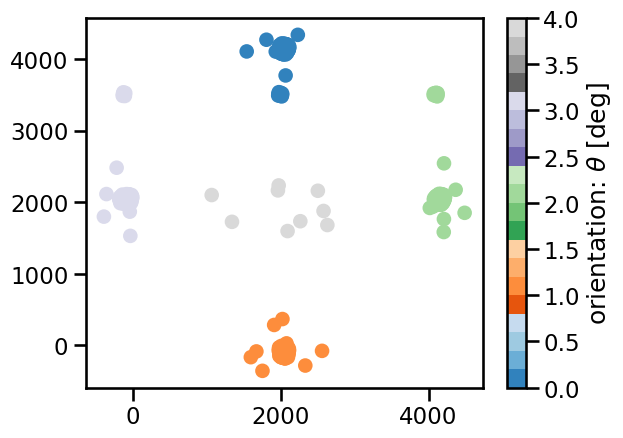

In [79]:
plt.scatter(data['GRID_X0'],data['GRID_Y0'],c=data['group'],cmap='tab20c')
plt.colorbar().set_label(r'orientation: $\theta$ [deg]')

## Compute Spacing

In [80]:
# # select only group 1 and 2 fisrt
# sel_g12 = (data['group'] == 1)|(data['group']==2)
# data[sel_g12]

In [81]:
pid = np.unique(data['pairID'])
offsetsX = np.full_like(data['GRID_X0'],np.nan)
offsetsY = np.full_like(data['GRID_X0'],np.nan)

for i in range(len(data)):
    ids = np.where(data['pairID']==data['pairID'][i])[0]
    if ids.size==2:
        offsetsX[i] = data['GRID_X0'][ids[0]]-data['GRID_X0'][ids[1]]
        offsetsY[i] = data['GRID_Y0'][ids[0]]-data['GRID_Y0'][ids[1]]

sensor_lims = {'e2v':[4096,4004],'ITL':[4072,4000]}
shiftX = np.where(data['ccd_type']=='ITL',sensor_lims['ITL'][0],sensor_lims['e2v'][0])
shiftY = np.where(data['ccd_type']=='ITL',sensor_lims['ITL'][1],sensor_lims['e2v'][1])

offsetsY = np.where(offsetsY>2000,offsetsY-shiftY,offsetsY)
offsetsX = np.where(offsetsX>2000,offsetsX-shiftX,offsetsX)
dR = np.hypot(offsetsX,offsetsY)
theta = 180-np.arctan2(offsetsY,offsetsX)*180./np.pi

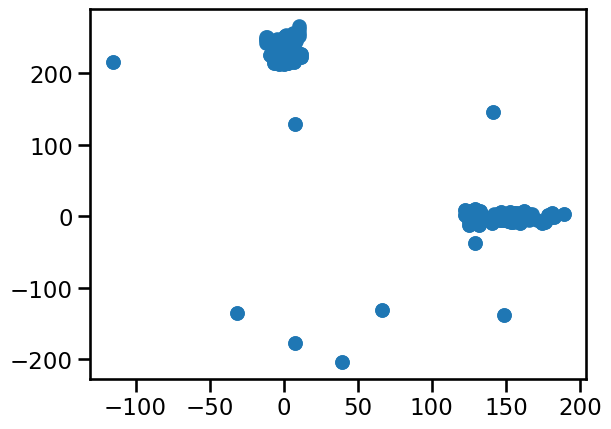

In [99]:
crop = dR<300.
plt.scatter(offsetsX[crop],offsetsY[crop])
# plt.colorbar()

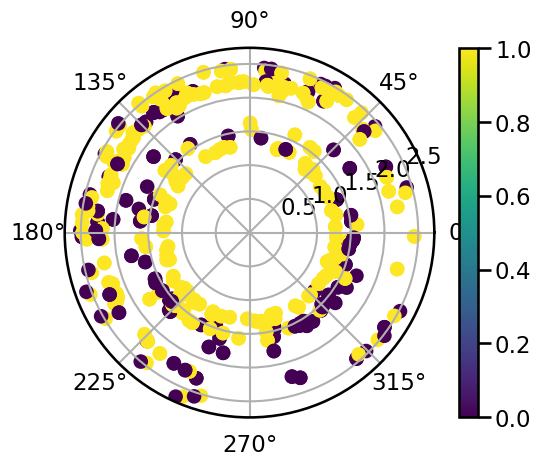

In [102]:
# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
im = ax.scatter(theta[crop], dR[crop]*0.01, c=np.where(data['ccd_type']=='ITL',0,1)[crop])
fig.colorbar(im)

(array([156.,  46., 107.,  17.,   6.,   6., 132.,  88.,  87.,   9.]),
 array([122.52832684, 136.94320315, 151.35807946, 165.77295576,
        180.18783207, 194.60270838, 209.01758469, 223.432461  ,
        237.8473373 , 252.26221361, 266.67708992]),
 <BarContainer object of 10 artists>)

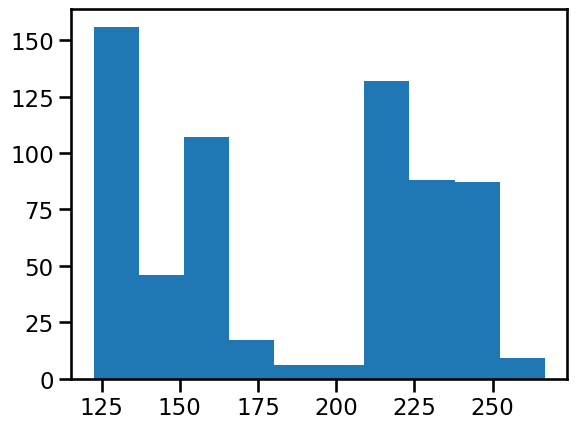

In [95]:
plt.hist(dR[crop])

(array([  2., 316.,   0.,   2.,   0., 322.,   2.,   2.,   4.,   4.]),
 array([ 61.96493291,  84.07894699, 106.19296108, 128.30697517,
        150.42098925, 172.53500334, 194.64901743, 216.76303151,
        238.8770456 , 260.99105969, 283.10507377]),
 <BarContainer object of 10 artists>)

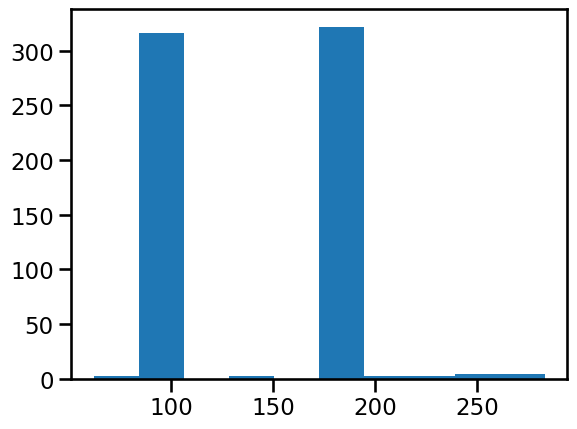

In [96]:
plt.hist(theta[crop])

In [86]:
from datetime import date
current_date = date.today()
data['dX'] = offsetsX
data['dY'] = offsetsY
data['dR'] = dR
data['theta'] = theta

data.write(f'fullRun-{current_date}.csv',overwrite=True)
print(f'Table saved: fullRun-{current_date}.csv')

Table saved: fullRun-2023-06-21.csv


In [87]:
from lsst.obs.lsst import LsstCam
camera = LsstCam.getCamera()
det_names = {i: det.getName() for i, det in enumerate(camera)}
det_nums = {det.getName():i for i, det in enumerate(camera)}

print(det_names[98],det_nums['R22_S22'])

R22_S22 98


In [66]:
from lsst.afw.cameraGeom import FOCAL_PLANE, FIELD_ANGLE
det = camera[98]
print(f"{det.getCenter(FIELD_ANGLE) = } (radians)")
print(f"{det.getCenter(FOCAL_PLANE) = } (mm)")

det.getCenter(FIELD_ANGLE) = Point2D(0.0040966756053755797, 0.0040966756053755797) (radians)
det.getCenter(FOCAL_PLANE) = Point2D(42.25, 42.25) (mm)


In [67]:
pnt = det.getCenter(FOCAL_PLANE)
pnt.setX(0)

In [37]:
# det.getTransform()

In [38]:
datasetRefs[0].

DatasetRef(DatasetType('gridSpotSrc', {band, instrument, detector, physical_filter, exposure}, SourceCatalog), {instrument: 'LSSTCam', detector: 0, exposure: 3021122200113, ...}, run='u/jesteves/2023.06.12/test_b/20230614T214434Z', id=9575099c-f394-4af0-a028-f241a852caf4)

In [97]:
butler.get('raw.metadata',datasetRefs[0].dataId).toDict()

{'SIMPLE': True,
 'EXTEND': True,
 'DATE': '2021-12-22T18:31:28.869',
 'MJD': 59570.77186190989,
 'RUNNUM': '13229',
 'CCD_MANU': 'ITL',
 'CCD_TYPE': '3800C',
 'TESTTYPE': 'SPOT_FLAT',
 'IMGTYPE': 'SPOT',
 'DETSIZE': '[1:4072,1:4000]',
 'EXPTIME': 16.0,
 'BINX': 1,
 'BINY': 1,
 'CCDGAIN': 1.0,
 'CCDNOISE': 10.0,
 'DATE-OBS': '2021-12-22T18:31:28.864',
 'MJD-OBS': 59570.77186185168,
 'DATE-TRG': '2021-12-22T18:31:28.864',
 'MJD-TRG': 59570.77186185168,
 'IMAGETAG': '83fc390aae76511e',
 'CCDSLOT': 'S00',
 'RAFTBAY': 'R01',
 'FIRMWARE': '31395007',
 'PLATFORM': 'ir2-camera',
 'CONTNUM': '18ed9486',
 'DAQVERS': 'R5-V0.11 2021-11-03T15:13:45Z (fbaf2dd)',
 'DAQPART': 'camera',
 'DAQFOLD': 'raw',
 'DAQANNOT': '450nm',
 'OBSID': 'MC_C_20211222_000113',
 'TELCODE': 'MC',
 'CONTRLLR': 'C',
 'DAYOBS': '20211222',
 'SEQNUM': 113,
 'HEADVER': 2,
 'INSTRUME': 'lsstCam',
 'TELESCOP': 'LSST',
 'TSTAND': 'BOT',
 'SEQFILE': 'FP_ITL_2s_ir2_v26.seq',
 'SEQCKSUM': '980618532',
 'LSST_NUM': 'ITL-3800C-083',